# Machine Analysis

These notebooks look to analyse the time spent by each patient at the different machines. They use the geopandas package to capture the points in the polygons representing the different machines. They then look to capture the time spent in that machine.

## Package and Function Load In

In [ ]:
def lookup(date_pd_series, format=None):
    """
    This is an extremely fast approach to datetime parsing.
    For large data, the same dates are often repeated. Rather than
    re-parse these, we store all unique dates, parse them, and
    use a lookup to convert all dates.
    """
    dates = {date:pd.to_datetime(date, format=format) for date in date_pd_series.unique()}
    return date_pd_series.map(dates)

In [ ]:
!pip install geopandas
!pip install fiona
!pip install pyproj
!pip install rtree
!pip install pygeos

     |████████████████████████████████| 1.0 MB 7.7 MB/s 
     |████████████████████████████████| 16.7 MB 317 kB/s 
     |████████████████████████████████| 6.3 MB 33.2 MB/s 
     |████████████████████████████████| 1.0 MB 8.5 MB/s 
     |████████████████████████████████| 2.1 MB 7.9 MB/s 


## File Load In

In this section you must load in the appropriate patient journey file for analysis.

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
from shapely.geometry import box
from shapely import wkt
import pandas as pd
import rtree
import pygeos
import geopandas as gpd
import numpy as np
import datetime as dt
import math
import seaborn as sns
import scipy.stats as sps
from scipy import stats
order_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
order_list_noweekend = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']


pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling

dftest = pd.read_csv('phase2_all_20220130.csv')

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## Creating the Machine Polygon or MultiPolygon

The polygon coordinates are captured using the line_with_coordinates.html file. The polygon coordinates must be entered in the order of top left, bottom left, bottom right and then top right.

In [ ]:
ORA_poly = Polygon([(18.4, 13.3), (18.4, 7.9), (25.1, 7.9), (25.1, 13.3)])

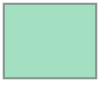

In [ ]:
ORA_poly

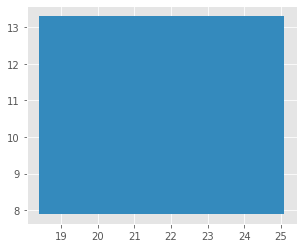

In [ ]:
 p = gpd.GeoSeries(ORA_poly)
 p.plot()
 plt.show()

## Data Cleaning and Formatting

In [ ]:
dftest = dftest.dropna()
dftest[['xlocation', 'ylocation']] = dftest['Location'].str.split(',', expand = True)

In [ ]:
dfG1221 = dftest.loc[dftest['Patient'] == 'G1221']

In [ ]:
column_list = list(dftest)
column_list

['Patient', 'Location', 'from', 'to', 'xlocation', 'ylocation']

## GeoPandas Dataframe Creation

This section creates a GeoPandas dataframe using the coordinates from the patient journey dataset.

The next section creates a geometry using the polygon or MultiPolygon shape that was created earlier.

In [ ]:
gdf = gpd.GeoDataFrame(
    dftest, geometry=gpd.points_from_xy(dftest.xlocation, dftest.ylocation))

In [ ]:
gdf['Location'] = gdf['Location'].astype(str)

In [ ]:
ORA_poly_gdf = gpd.GeoDataFrame(geometry  = gpd.GeoSeries(ORA_poly))

In [ ]:
ORA_poly_gdf

,geometry
0,"POLYGON ((18.40000 13.30000, 18.40000 7.90000,..."


## Inner Join of the Two GeoPandas DataFrames

This section runs a spatial join of the two GeoDataframes it captures all of the points, in this example the patient journey points, that occur with in the polygon or MultiPolygon that was created earlier. This represents the time spent by the patient in the machine.

In [ ]:
AF_join = gpd.sjoin(gdf, ORA_poly_gdf, how = 'inner')
AF_join

,Patient,Location,from,to,xlocation,ylocation,geometry,index_right
31,G1221,"20.196,8.757",30/11/2021 10:23,30/11/2021 10:23,20.196,8.757,POINT (20.19600 8.75700),0
70,G1221,"21.453,7.96",30/11/2021 10:43,30/11/2021 10:43,21.453,7.96,POINT (21.45300 7.96000),0
71,G1221,"22.464,8.767",30/11/2021 10:43,30/11/2021 10:43,22.464,8.767,POINT (22.46400 8.76700),0
72,G1221,"21.778,9.503",30/11/2021 10:43,30/11/2021 10:43,21.778,9.503,POINT (21.77800 9.50300),0
73,G1221,"22.464,8.767",30/11/2021 10:43,30/11/2021 10:43,22.464,8.767,POINT (22.46400 8.76700),0
...,...,...,...,...,...,...,...,...
105511,R2000,"22.262,7.925",20/12/2021 10:11,20/12/2021 10:11,22.262,7.925,POINT (22.26200 7.92500),0
105512,R2000,"24.187,7.941",20/12/2021 10:11,20/12/2021 10:11,24.187,7.941,POINT (24.18700 7.94100),0
105643,R2000,"20.196,8.757",20/12/2021 10:37,20/12/2021 10:37,20.196,8.757,POINT (20.19600 8.75700),0
105690,R4000,"18.921,7.943",20/12/2021 11:20,20/12/2021 11:20,18.921,7.943,POINT (18.92100 7.94300),0


## More data cleaning

## Setting up the data for analysis

This analysis now follows the code that was done in the phase 1, phase 2 and phase 3 notebooks. There are more detailed instructions in those notebooks.

The analysis and the outputs match the work done in those notebooks exactly from this point onwards.

In [ ]:
AF_join['newfrom'] = lookup(AF_join['from'], format='%d/%m/%Y %H:%M')
AF_join['newto'] = lookup(AF_join['to'], format='%d/%m/%Y %H:%M')

In [ ]:
dfgrouped = AF_join.groupby('Patient', as_index = False).agg({'newfrom': ['min'], 'newto': ['max']})

In [ ]:
flat_cols = []
for i in dfgrouped.columns:
    flat_cols.append(i[0]+'_'+i[1])

In [ ]:
dfgrouped.columns = flat_cols

In [ ]:
dfgrouped = dfgrouped.rename(columns={'Patient_': 'Patient'})
dfgrouped = dfgrouped.rename(columns={'newfrom_min': 'newfrom'})
dfgrouped = dfgrouped.rename(columns={'newto_max': 'newto'})

In [ ]:
dfgrouped

,Patient,newfrom,newto
0,G1221,2021-11-30 10:23:00,2021-11-30 11:01:00
1,G1223,2021-11-30 11:35:00,2021-11-30 11:50:00
2,G1224,2021-11-30 10:31:00,2021-11-30 10:44:00
3,G1225,2021-11-30 10:45:00,2021-11-30 11:02:00
4,G1226,2021-11-30 10:46:00,2021-11-30 11:25:00
...,...,...,...
795,R1304,2022-01-28 10:43:00,2022-01-28 15:54:00
796,R1305,2022-01-28 10:43:00,2022-01-28 15:54:00
797,R1306,2022-01-28 10:43:00,2022-01-28 15:54:00
798,R2000,2021-12-20 10:11:00,2021-12-20 10:37:00


In [ ]:
dfgrouped['visit_length'] = dfgrouped['newto'] - dfgrouped['newfrom']

In [ ]:
dfgrouped['start_day'] = dfgrouped['newfrom'].dt.day
dfgrouped['end_day'] = dfgrouped['newto'].dt.day

In [ ]:
conditions = [dfgrouped['start_day'] == dfgrouped['end_day'], dfgrouped['start_day'] != dfgrouped['end_day']]
choices = ['equal', 'not_equal']
dfgrouped['sameday'] = np.select(conditions, choices)
dfgrouped['sameday'].unique()

array(['equal', 'not_equal'], dtype=object)

In [ ]:
dfgrouped = dfgrouped.drop(dfgrouped[dfgrouped.sameday == 'not_equal'].index)


In [ ]:
dfgrouped['visit_length'].max()

Timedelta('0 days 05:11:00')

In [ ]:
dfgrouped

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday
0,G1221,2021-11-30 10:23:00,2021-11-30 11:01:00,0 days 00:38:00,30,30,equal
1,G1223,2021-11-30 11:35:00,2021-11-30 11:50:00,0 days 00:15:00,30,30,equal
2,G1224,2021-11-30 10:31:00,2021-11-30 10:44:00,0 days 00:13:00,30,30,equal
3,G1225,2021-11-30 10:45:00,2021-11-30 11:02:00,0 days 00:17:00,30,30,equal
4,G1226,2021-11-30 10:46:00,2021-11-30 11:25:00,0 days 00:39:00,30,30,equal
...,...,...,...,...,...,...,...
795,R1304,2022-01-28 10:43:00,2022-01-28 15:54:00,0 days 05:11:00,28,28,equal
796,R1305,2022-01-28 10:43:00,2022-01-28 15:54:00,0 days 05:11:00,28,28,equal
797,R1306,2022-01-28 10:43:00,2022-01-28 15:54:00,0 days 05:11:00,28,28,equal
798,R2000,2021-12-20 10:11:00,2021-12-20 10:37:00,0 days 00:26:00,20,20,equal


In [ ]:
dfgrouped['visit_length'].max()

Timedelta('0 days 05:11:00')

In [ ]:
dfgrouped['visit_length'].describe()

count                          798
mean     0 days 00:17:07.894736842
std      0 days 00:25:45.003466944
min                0 days 00:00:00
25%                0 days 00:09:00
50%                0 days 00:14:00
75%                0 days 00:19:45
max                0 days 05:11:00
Name: visit_length, dtype: object

In [ ]:
dfgrouped['dayofweek'] = dfgrouped['newfrom'].dt.day_name()
df_final= dfgrouped.dropna()

In [ ]:
dfgrouped

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek
0,G1221,2021-11-30 10:23:00,2021-11-30 11:01:00,0 days 00:38:00,30,30,equal,Tuesday
1,G1223,2021-11-30 11:35:00,2021-11-30 11:50:00,0 days 00:15:00,30,30,equal,Tuesday
2,G1224,2021-11-30 10:31:00,2021-11-30 10:44:00,0 days 00:13:00,30,30,equal,Tuesday
3,G1225,2021-11-30 10:45:00,2021-11-30 11:02:00,0 days 00:17:00,30,30,equal,Tuesday
4,G1226,2021-11-30 10:46:00,2021-11-30 11:25:00,0 days 00:39:00,30,30,equal,Tuesday
...,...,...,...,...,...,...,...,...
795,R1304,2022-01-28 10:43:00,2022-01-28 15:54:00,0 days 05:11:00,28,28,equal,Friday
796,R1305,2022-01-28 10:43:00,2022-01-28 15:54:00,0 days 05:11:00,28,28,equal,Friday
797,R1306,2022-01-28 10:43:00,2022-01-28 15:54:00,0 days 05:11:00,28,28,equal,Friday
798,R2000,2021-12-20 10:11:00,2021-12-20 10:37:00,0 days 00:26:00,20,20,equal,Monday


In [ ]:
df_final

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek
0,G1221,2021-11-30 10:23:00,2021-11-30 11:01:00,0 days 00:38:00,30,30,equal,Tuesday
1,G1223,2021-11-30 11:35:00,2021-11-30 11:50:00,0 days 00:15:00,30,30,equal,Tuesday
2,G1224,2021-11-30 10:31:00,2021-11-30 10:44:00,0 days 00:13:00,30,30,equal,Tuesday
3,G1225,2021-11-30 10:45:00,2021-11-30 11:02:00,0 days 00:17:00,30,30,equal,Tuesday
4,G1226,2021-11-30 10:46:00,2021-11-30 11:25:00,0 days 00:39:00,30,30,equal,Tuesday
...,...,...,...,...,...,...,...,...
795,R1304,2022-01-28 10:43:00,2022-01-28 15:54:00,0 days 05:11:00,28,28,equal,Friday
796,R1305,2022-01-28 10:43:00,2022-01-28 15:54:00,0 days 05:11:00,28,28,equal,Friday
797,R1306,2022-01-28 10:43:00,2022-01-28 15:54:00,0 days 05:11:00,28,28,equal,Friday
798,R2000,2021-12-20 10:11:00,2021-12-20 10:37:00,0 days 00:26:00,20,20,equal,Monday


In [ ]:
dayoftheweekmean = df_final.groupby('dayofweek')['visit_length'].mean(numeric_only=False)
dayoftheweekmean = dayoftheweekmean.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [ ]:
def ftod(x):
    if (x>13):
        tod = 'afternoon'
    else:
        tod = 'morning'
    return tod

In [ ]:
df_final['tod'] = df_final.newfrom.dt.hour.map(ftod) 

In [ ]:
timeofdaymean = df_final.groupby('tod')['visit_length'].mean(numeric_only=False)

In [ ]:
timeofdaymean

tod
afternoon   0 days 00:14:16.078431372
morning     0 days 00:18:54.756097560
Name: visit_length, dtype: timedelta64[ns]

In [ ]:
df_dayoftheweekmean = pd.DataFrame(data=dayoftheweekmean)

In [ ]:
df_dayoftheweekmean

,visit_length
dayofweek,
Monday,0 days 00:14:52.363636363
Tuesday,0 days 00:15:18.288770053
Wednesday,0 days 00:13:50.109890109
Thursday,0 days 00:18:56.271186440
Friday,0 days 00:23:15.633802816
Saturday,NaT
Sunday,NaT


In [ ]:
print('Monday')
Monday_count = df_final['dayofweek'][df_final['dayofweek']=='Monday'].count()
print(Monday_count)

print('Tuesday')
Tuesday_count = df_final['dayofweek'][df_final['dayofweek']=='Tuesday'].count()
print(Tuesday_count)

print('Wednesday')
Wednesday_count = df_final['dayofweek'][df_final['dayofweek']=='Wednesday'].count()
print(Wednesday_count)

print('Thursday')
Thursday_count = df_final['dayofweek'][df_final['dayofweek']=='Thursday'].count()
print(Thursday_count)

print('Friday')
Friday_count = df_final['dayofweek'][df_final['dayofweek']=='Friday'].count()
print(Friday_count)

print('Saturday')
Saturday_count = df_final['dayofweek'][df_final['dayofweek']=='Saturday'].count()
print(Saturday_count)

print('Sunday')
Sunday_count = df_final['dayofweek'][df_final['dayofweek']=='Sunday'].count()
print(Sunday_count)

Monday
110
Tuesday
187
Wednesday
182
Thursday
177
Friday
142
Saturday
0
Sunday
0


In [ ]:
weekday_data = {'dayofweek':['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
          'count': [Monday_count , Tuesday_count , Wednesday_count , Thursday_count , Friday_count , Saturday_count , Sunday_count ]}
weekday_df = pd.DataFrame(weekday_data)

In [ ]:
df_final['hour'] = df_final['newfrom'].dt.hour

In [ ]:
df_final

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour
0,G1221,2021-11-30 10:23:00,2021-11-30 11:01:00,0 days 00:38:00,30,30,equal,Tuesday,morning,10
1,G1223,2021-11-30 11:35:00,2021-11-30 11:50:00,0 days 00:15:00,30,30,equal,Tuesday,morning,11
2,G1224,2021-11-30 10:31:00,2021-11-30 10:44:00,0 days 00:13:00,30,30,equal,Tuesday,morning,10
3,G1225,2021-11-30 10:45:00,2021-11-30 11:02:00,0 days 00:17:00,30,30,equal,Tuesday,morning,10
4,G1226,2021-11-30 10:46:00,2021-11-30 11:25:00,0 days 00:39:00,30,30,equal,Tuesday,morning,10
...,...,...,...,...,...,...,...,...,...,...
795,R1304,2022-01-28 10:43:00,2022-01-28 15:54:00,0 days 05:11:00,28,28,equal,Friday,morning,10
796,R1305,2022-01-28 10:43:00,2022-01-28 15:54:00,0 days 05:11:00,28,28,equal,Friday,morning,10
797,R1306,2022-01-28 10:43:00,2022-01-28 15:54:00,0 days 05:11:00,28,28,equal,Friday,morning,10
798,R2000,2021-12-20 10:11:00,2021-12-20 10:37:00,0 days 00:26:00,20,20,equal,Monday,morning,10


In [ ]:
hourlymean = df_final.groupby('hour')['visit_length'].mean(numeric_only=False)

In [ ]:
hourlymean

hour
10   0 days 00:30:16.363636363
11   0 days 00:16:31.290322580
12   0 days 00:14:35.636363636
13   0 days 00:15:56.129032258
14   0 days 00:14:53.885350318
15   0 days 00:14:46.271186440
16   0 days 00:09:09.677419354
Name: visit_length, dtype: timedelta64[ns]

In [ ]:
df_final.dtypes

Patient                  object
newfrom          datetime64[ns]
newto            datetime64[ns]
visit_length    timedelta64[ns]
start_day                 int64
end_day                   int64
sameday                  object
dayofweek                object
tod                      object
hour                      int64
dtype: object

In [ ]:
print('Nine')
nine_count = df_final['hour'][df_final['hour']==9].count()
print(nine_count)

print('Ten')
ten_count = df_final['hour'][df_final['hour']==10].count()
print(ten_count)

print('Eleven')
eleven_count = df_final['hour'][df_final['hour']==11].count()
print(eleven_count)

print('Twelve')
twelve_count = df_final['hour'][df_final['hour']==12].count()
print(twelve_count)

print('One')
one_count = df_final['hour'][df_final['hour']==13].count()
print(one_count)

print('Two')
two_count = df_final['hour'][df_final['hour']==14].count()
print(two_count)

print('Three')
three_count = df_final['hour'][df_final['hour']==15].count()
print(three_count)

print('Four')
four_count = df_final['hour'][df_final['hour']==16].count()
print(four_count)

Nine
0
Ten
110
Eleven
186
Twelve
165
One
31
Two
157
Three
118
Four
31


In [ ]:
df_final['condition'] = df_final['Patient'].str[0]

In [ ]:
conditionmean = df_final.groupby('condition')['visit_length'].mean(numeric_only=False)

In [ ]:
conditionmean

condition
G   0 days 00:17:15.284810126
R   0 days 00:16:39.759036144
Name: visit_length, dtype: timedelta64[ns]

In [ ]:
print('Glaucoma')
glaucoma_count = df_final['condition'][df_final['condition']=='G'].count()
print(glaucoma_count)

print('Medical Retinal')
retina_count = df_final['condition'][df_final['condition']=='R'].count()
print(retina_count)

Glaucoma
632
Medical Retinal
166


In [ ]:
def get_seconds(time_delta):
    return time_delta.seconds

time_delta_series = df_final['visit_length']

df_final['visit_length_minutes'] = time_delta_series.apply(get_seconds)

In [ ]:
df_final['visit_length_minutes'] = df_final['visit_length_minutes'] / 60

In [ ]:
df_final

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
0,G1221,2021-11-30 10:23:00,2021-11-30 11:01:00,0 days 00:38:00,30,30,equal,Tuesday,morning,10,G,38.0000
1,G1223,2021-11-30 11:35:00,2021-11-30 11:50:00,0 days 00:15:00,30,30,equal,Tuesday,morning,11,G,15.0000
2,G1224,2021-11-30 10:31:00,2021-11-30 10:44:00,0 days 00:13:00,30,30,equal,Tuesday,morning,10,G,13.0000
3,G1225,2021-11-30 10:45:00,2021-11-30 11:02:00,0 days 00:17:00,30,30,equal,Tuesday,morning,10,G,17.0000
4,G1226,2021-11-30 10:46:00,2021-11-30 11:25:00,0 days 00:39:00,30,30,equal,Tuesday,morning,10,G,39.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
795,R1304,2022-01-28 10:43:00,2022-01-28 15:54:00,0 days 05:11:00,28,28,equal,Friday,morning,10,R,311.0000
796,R1305,2022-01-28 10:43:00,2022-01-28 15:54:00,0 days 05:11:00,28,28,equal,Friday,morning,10,R,311.0000
797,R1306,2022-01-28 10:43:00,2022-01-28 15:54:00,0 days 05:11:00,28,28,equal,Friday,morning,10,R,311.0000
798,R2000,2021-12-20 10:11:00,2021-12-20 10:37:00,0 days 00:26:00,20,20,equal,Monday,morning,10,R,26.0000


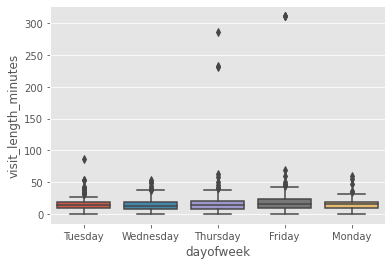

In [ ]:
axdayoftheweek = sns.boxplot(x="dayofweek", y="visit_length_minutes", data=df_final)

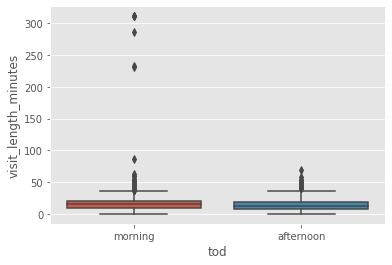

In [ ]:
axtod = sns.boxplot(x="tod", y="visit_length_minutes", data=df_final)

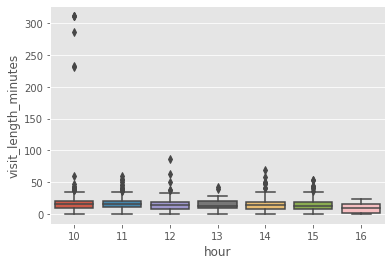

In [ ]:
axhour = sns.boxplot(x="hour", y="visit_length_minutes", data=df_final)

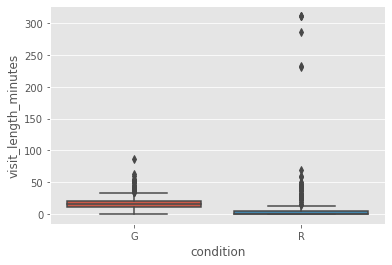

In [ ]:
axcondition = sns.boxplot(x="condition", y="visit_length_minutes", data=df_final)

In [ ]:
df_outliers = df_final[(np.abs(stats.zscore(df_final['visit_length_minutes'])) < 3)]
df_outliers.loc[(df_outliers[['visit_length_minutes']] < 10).all(axis=1)]
print(df_outliers.loc[(df_outliers[['visit_length_minutes']] < 10).all(axis=1)].count())

Patient                 225
newfrom                 225
newto                   225
visit_length            225
start_day               225
end_day                 225
sameday                 225
dayofweek               225
tod                     225
hour                    225
condition               225
visit_length_minutes    225
dtype: int64


In [ ]:
df_nozero = df_outliers.loc[(df_outliers[['visit_length_minutes']] != 0).all(axis=1)]
df_nozero

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
0,G1221,2021-11-30 10:23:00,2021-11-30 11:01:00,0 days 00:38:00,30,30,equal,Tuesday,morning,10,G,38.0000
1,G1223,2021-11-30 11:35:00,2021-11-30 11:50:00,0 days 00:15:00,30,30,equal,Tuesday,morning,11,G,15.0000
2,G1224,2021-11-30 10:31:00,2021-11-30 10:44:00,0 days 00:13:00,30,30,equal,Tuesday,morning,10,G,13.0000
3,G1225,2021-11-30 10:45:00,2021-11-30 11:02:00,0 days 00:17:00,30,30,equal,Tuesday,morning,10,G,17.0000
4,G1226,2021-11-30 10:46:00,2021-11-30 11:25:00,0 days 00:39:00,30,30,equal,Tuesday,morning,10,G,39.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
787,R1244,2022-01-26 11:54:00,2022-01-26 11:57:00,0 days 00:03:00,26,26,equal,Wednesday,morning,11,R,3.0000
789,R1254,2022-01-27 10:34:00,2022-01-27 10:38:00,0 days 00:04:00,27,27,equal,Thursday,morning,10,R,4.0000
790,R1256,2022-01-27 12:12:00,2022-01-27 12:14:00,0 days 00:02:00,27,27,equal,Thursday,morning,12,R,2.0000
792,R1301,2022-01-27 10:08:00,2022-01-27 10:34:00,0 days 00:26:00,27,27,equal,Thursday,morning,10,R,26.0000


In [ ]:
mean = df_outliers['visit_length_minutes'].mean()
print(mean)
print(df_nozero['visit_length_minutes'].mean())

15.137626262626263
17.502189781021897


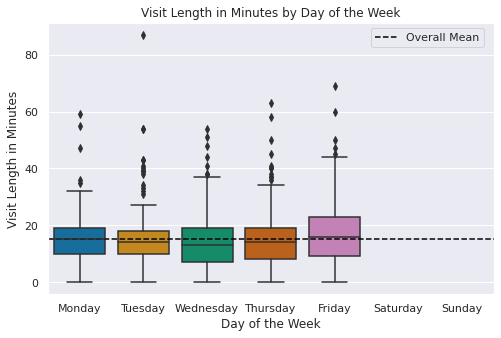

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="dayofweek", y="visit_length_minutes", data=df_outliers, order = order_list)
svm.set_title('Visit Length in Minutes by Day of the Week')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Day of the Week')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('dayofweek_updated.png', bbox_inches='tight')

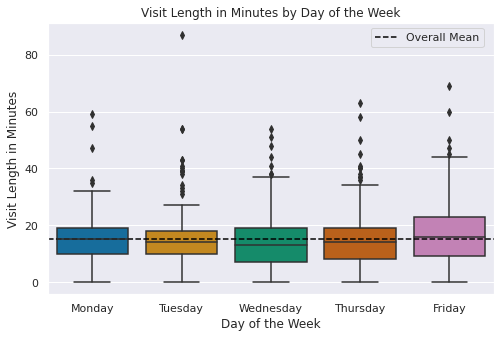

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="dayofweek", y="visit_length_minutes", data=df_outliers, order = order_list_noweekend)
svm.set_title('Visit Length in Minutes by Day of the Week')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Day of the Week')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('dayofweek_updated_noweekend.png', bbox_inches='tight')

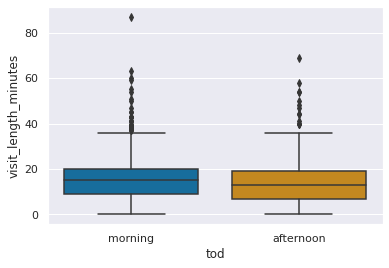

In [ ]:
axtod = sns.boxplot(x="tod", y="visit_length_minutes", data=df_outliers)

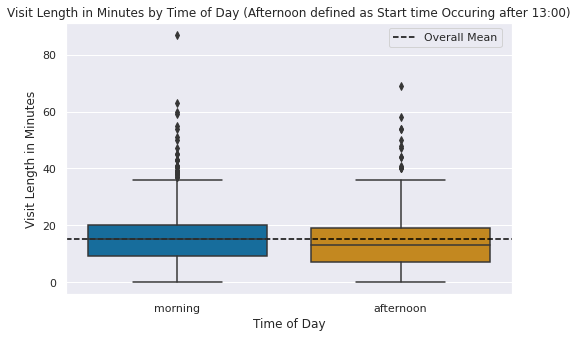

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="tod", y="visit_length_minutes", data=df_outliers)
svm.set_title('Visit Length in Minutes by Time of Day (Afternoon defined as Start time Occuring after 13:00)')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Time of Day')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('timeofday_updated.png', bbox_inches='tight')

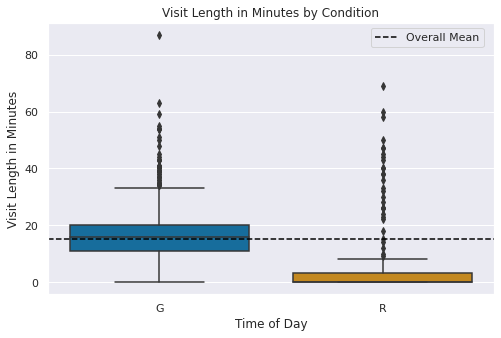

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="condition", y="visit_length_minutes", data=df_outliers)
svm.set_title('Visit Length in Minutes by Condition')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Time of Day')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('condition_updated.png', bbox_inches='tight')

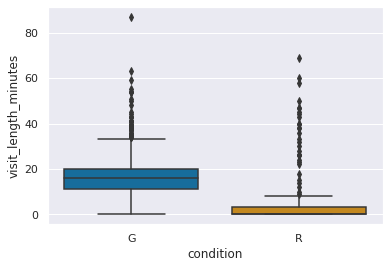

In [ ]:
axcondition = sns.boxplot(x="condition", y="visit_length_minutes", data=df_outliers)

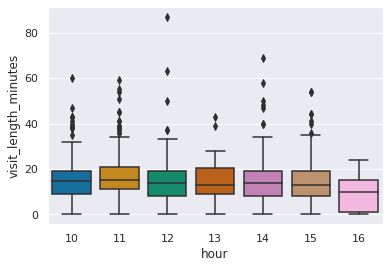

In [ ]:
axhour = sns.boxplot(x="hour", y="visit_length_minutes", data=df_outliers)

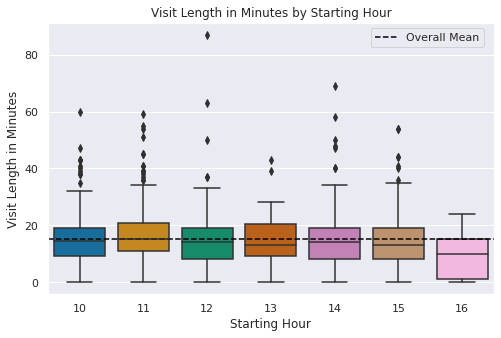

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="hour", y="visit_length_minutes", data=df_outliers)
svm.set_title('Visit Length in Minutes by Starting Hour')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Starting Hour')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('hour_updated.png', bbox_inches='tight')

In [ ]:
dayoftheweekmean = df_outliers.groupby('dayofweek')['visit_length'].mean(numeric_only=False)
dayoftheweekmean = dayoftheweekmean.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [ ]:
df_outliers['visit_length_minutes'].describe()

count                                   792.0000
mean                                     15.1376
std                                      11.3579
min                                       0.0000
25%                                       9.0000
50%                                      14.0000
75%                                      19.0000
max                                      87.0000
Name: visit_length_minutes, dtype: float64

In [ ]:
df_final['visit_length_minutes'].describe()

count                                   798.0000
mean                                     17.1316
std                                      25.7501
min                                       0.0000
25%                                       9.0000
50%                                      14.0000
75%                                      19.7500
max                                     311.0000
Name: visit_length_minutes, dtype: float64

In [ ]:
df_final['visit_length_minutes'].median()

14.0

In [ ]:
df_outliers['visit_length'].describe()

count                          792
mean     0 days 00:15:08.257575757
std      0 days 00:11:21.472336529
min                0 days 00:00:00
25%                0 days 00:09:00
50%                0 days 00:14:00
75%                0 days 00:19:00
max                0 days 01:27:00
Name: visit_length, dtype: object

In [ ]:
df_final['visit_length'].describe()

count                          798
mean     0 days 00:17:07.894736842
std      0 days 00:25:45.003466944
min                0 days 00:00:00
25%                0 days 00:09:00
50%                0 days 00:14:00
75%                0 days 00:19:45
max                0 days 05:11:00
Name: visit_length, dtype: object

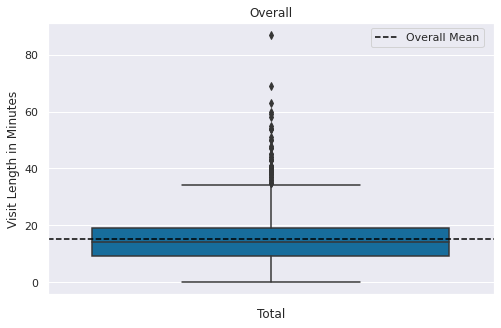

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(y="visit_length_minutes", data=df_outliers)
svm.set_title('Overall')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Total')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('tested.png', bbox_inches='tight')

In [ ]:
print('Nine')
nine_count = df_outliers['hour'][df_outliers['hour']==9].count()
print(nine_count)

print('Ten')
ten_count = df_outliers['hour'][df_outliers['hour']==10].count()
print(ten_count)

print('Eleven')
eleven_count = df_outliers['hour'][df_outliers['hour']==11].count()
print(eleven_count)

print('Twelve')
twelve_count = df_outliers['hour'][df_outliers['hour']==12].count()
print(twelve_count)

print('One')
one_count = df_outliers['hour'][df_outliers['hour']==13].count()
print(one_count)

print('Two')
two_count = df_outliers['hour'][df_outliers['hour']==14].count()
print(two_count)

print('Three')
three_count = df_outliers['hour'][df_outliers['hour']==15].count()
print(three_count)

print('Four')
four_count = df_outliers['hour'][df_outliers['hour']==16].count()
print(four_count)

Nine
0
Ten
104
Eleven
186
Twelve
165
One
31
Two
157
Three
118
Four
31


In [ ]:
print('Monday Outlier')
mondayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Monday'].count()
print(mondayoutlier)

print('Tuesday Outlier')
tuesdayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Tuesday'].count()
print(tuesdayoutlier)

print('Wednesday Outlier')
wednesdayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Wednesday'].count()
print(wednesdayoutlier)

print('Thursday Outlier')
thursdayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Thursday'].count()
print(thursdayoutlier)

print('Friday Outlier')
fridayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Friday'].count()
print(fridayoutlier)

print('Saturday Outlier')
saturdayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Saturday'].count()
print(saturdayoutlier)

print('Sunday Outlier')
sundayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Sunday'].count()
print(sundayoutlier)

Monday Outlier
110
Tuesday Outlier
187
Wednesday Outlier
182
Thursday Outlier
174
Friday Outlier
139
Saturday Outlier
0
Sunday Outlier
0


In [ ]:
dayoftheweekmean = df_outliers.groupby('dayofweek')['visit_length_minutes'].mean(numeric_only=False)
dayoftheweekmean = dayoftheweekmean.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [ ]:
dayoftheweekmean

dayofweek
Monday                                       14.8727
Tuesday                                      15.3048
Wednesday                                    13.8352
Thursday                                     14.9598
Friday                                       17.0504
Saturday                                         NaN
Sunday                                           NaN
Name: visit_length_minutes, dtype: float64

In [ ]:
print('G')
glaucomacount = df_outliers['condition'][df_outliers['condition']=='G'].count()
print(glaucomacount)

print('R')
rcount = df_outliers['condition'][df_outliers['condition']=='R'].count()
print(rcount)

G
632
R
160


In [ ]:
conditionmean = df_outliers.groupby('condition')['visit_length_minutes'].mean(numeric_only=False)
conditionmean

condition
G                                    17.2547
R                                     6.7750
Name: visit_length_minutes, dtype: float64

In [ ]:
print('morning')
morningcount = df_outliers['tod'][df_outliers['tod']=='morning'].count()
print(morningcount)

print('afternoon')
afternooncount = df_outliers['tod'][df_outliers['tod']=='afternoon'].count()
print(afternooncount)

morning
486
afternoon
306


In [ ]:
todmean = df_outliers.groupby('tod')['visit_length_minutes'].mean(numeric_only=False)
todmean

tod
afternoon                                    14.2680
morning                                      15.6852
Name: visit_length_minutes, dtype: float64

In [ ]:
print('Nine')
nine_count = df_outliers['hour'][df_outliers['hour']==9].count()
print(nine_count)

print('Ten')
ten_count = df_outliers['hour'][df_outliers['hour']==10].count()
print(ten_count)

print('Eleven')
eleven_count = df_outliers['hour'][df_outliers['hour']==11].count()
print(eleven_count)

print('Twelve')
twelve_count = df_outliers['hour'][df_outliers['hour']==12].count()
print(twelve_count)

print('One')
one_count = df_outliers['hour'][df_outliers['hour']==13].count()
print(one_count)

print('Two')
two_count = df_outliers['hour'][df_outliers['hour']==14].count()
print(two_count)

print('Three')
three_count = df_outliers['hour'][df_outliers['hour']==15].count()
print(three_count)

print('Four')
four_count = df_outliers['hour'][df_outliers['hour']==16].count()
print(four_count)

Nine
0
Ten
104
Eleven
186
Twelve
165
One
31
Two
157
Three
118
Four
31


In [ ]:
hourmean = df_outliers.groupby('hour')['visit_length_minutes'].mean(numeric_only=False)
hourmean

hour
10                                    15.8462
11                                    16.5215
12                                    14.5939
13                                    15.9355
14                                    14.8981
15                                    14.7712
16                                     9.1613
Name: visit_length_minutes, dtype: float64

In [ ]:
df_outliers.loc[(df_outliers[['visit_length_minutes']] < 10).all(axis=1)].count()

Patient                 225
newfrom                 225
newto                   225
visit_length            225
start_day               225
end_day                 225
sameday                 225
dayofweek               225
tod                     225
hour                    225
condition               225
visit_length_minutes    225
dtype: int64

In [ ]:
df_outliers.loc[(df_outliers[['visit_length_minutes']] == 0).all(axis=1)].count()

Patient                 107
newfrom                 107
newto                   107
visit_length            107
start_day               107
end_day                 107
sameday                 107
dayofweek               107
tod                     107
hour                    107
condition               107
visit_length_minutes    107
dtype: int64

In [ ]:
df_outliers.loc[(df_outliers[['visit_length']]).all(axis=1)].count()

Patient                 685
newfrom                 685
newto                   685
visit_length            685
start_day               685
end_day                 685
sameday                 685
dayofweek               685
tod                     685
hour                    685
condition               685
visit_length_minutes    685
dtype: int64

In [ ]:
df_outliers.nsmallest(5, 'visit_length')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
215,G1451,2021-12-21 14:46:00,2021-12-21 14:46:00,0 days,21,21,equal,Tuesday,afternoon,14,G,0.0000
243,G1481,2021-12-24 11:28:00,2021-12-24 11:28:00,0 days,24,24,equal,Friday,morning,11,G,0.0000
446,G1699,2022-01-17 15:54:00,2022-01-17 15:54:00,0 days,17,17,equal,Monday,afternoon,15,G,0.0000
634,R0869,2021-11-30 10:56:00,2021-11-30 10:56:00,0 days,30,30,equal,Tuesday,morning,10,R,0.0000
635,R0870,2021-11-30 12:01:00,2021-11-30 12:01:00,0 days,30,30,equal,Tuesday,morning,12,R,0.0000


In [ ]:
df_outliers.nsmallest(5, 'visit_length_minutes')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
215,G1451,2021-12-21 14:46:00,2021-12-21 14:46:00,0 days,21,21,equal,Tuesday,afternoon,14,G,0.0000
243,G1481,2021-12-24 11:28:00,2021-12-24 11:28:00,0 days,24,24,equal,Friday,morning,11,G,0.0000
446,G1699,2022-01-17 15:54:00,2022-01-17 15:54:00,0 days,17,17,equal,Monday,afternoon,15,G,0.0000
634,R0869,2021-11-30 10:56:00,2021-11-30 10:56:00,0 days,30,30,equal,Tuesday,morning,10,R,0.0000
635,R0870,2021-11-30 12:01:00,2021-11-30 12:01:00,0 days,30,30,equal,Tuesday,morning,12,R,0.0000


In [ ]:
df_outliers.nlargest(5, 'visit_length_minutes')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
205,G1440,2021-12-21 12:17:00,2021-12-21 13:44:00,0 days 01:27:00,21,21,equal,Tuesday,morning,12,G,87.0000
749,R1145,2022-01-14 14:05:00,2022-01-14 15:14:00,0 days 01:09:00,14,14,equal,Friday,afternoon,14,R,69.0000
341,G1581,2022-01-06 12:17:00,2022-01-06 13:20:00,0 days 01:03:00,6,6,equal,Thursday,morning,12,G,63.0000
718,R1033,2021-12-31 10:15:00,2021-12-31 11:15:00,0 days 01:00:00,31,31,equal,Friday,morning,10,R,60.0000
631,G4010,2021-12-20 11:36:00,2021-12-20 12:35:00,0 days 00:59:00,20,20,equal,Monday,morning,11,G,59.0000


In [ ]:
df_outliers.nlargest(5, 'visit_length')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
205,G1440,2021-12-21 12:17:00,2021-12-21 13:44:00,0 days 01:27:00,21,21,equal,Tuesday,morning,12,G,87.0000
749,R1145,2022-01-14 14:05:00,2022-01-14 15:14:00,0 days 01:09:00,14,14,equal,Friday,afternoon,14,R,69.0000
341,G1581,2022-01-06 12:17:00,2022-01-06 13:20:00,0 days 01:03:00,6,6,equal,Thursday,morning,12,G,63.0000
718,R1033,2021-12-31 10:15:00,2021-12-31 11:15:00,0 days 01:00:00,31,31,equal,Friday,morning,10,R,60.0000
631,G4010,2021-12-20 11:36:00,2021-12-20 12:35:00,0 days 00:59:00,20,20,equal,Monday,morning,11,G,59.0000


In [ ]:
df_final.nlargest(20, 'visit_length')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
795,R1304,2022-01-28 10:43:00,2022-01-28 15:54:00,0 days 05:11:00,28,28,equal,Friday,morning,10,R,311.0000
796,R1305,2022-01-28 10:43:00,2022-01-28 15:54:00,0 days 05:11:00,28,28,equal,Friday,morning,10,R,311.0000
797,R1306,2022-01-28 10:43:00,2022-01-28 15:54:00,0 days 05:11:00,28,28,equal,Friday,morning,10,R,311.0000
794,R1303,2022-01-27 10:08:00,2022-01-27 14:54:00,0 days 04:46:00,27,27,equal,Thursday,morning,10,R,286.0000
791,R1300,2022-01-27 10:07:00,2022-01-27 13:59:00,0 days 03:52:00,27,27,equal,Thursday,morning,10,R,232.0000
793,R1302,2022-01-27 10:08:00,2022-01-27 13:59:00,0 days 03:51:00,27,27,equal,Thursday,morning,10,R,231.0000
205,G1440,2021-12-21 12:17:00,2021-12-21 13:44:00,0 days 01:27:00,21,21,equal,Tuesday,morning,12,G,87.0000
749,R1145,2022-01-14 14:05:00,2022-01-14 15:14:00,0 days 01:09:00,14,14,equal,Friday,afternoon,14,R,69.0000
341,G1581,2022-01-06 12:17:00,2022-01-06 13:20:00,0 days 01:03:00,6,6,equal,Thursday,morning,12,G,63.0000
718,R1033,2021-12-31 10:15:00,2021-12-31 11:15:00,0 days 01:00:00,31,31,equal,Friday,morning,10,R,60.0000


In [ ]:
df_outliers.nlargest(20, 'visit_length')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
205,G1440,2021-12-21 12:17:00,2021-12-21 13:44:00,0 days 01:27:00,21,21,equal,Tuesday,morning,12,G,87.0000
749,R1145,2022-01-14 14:05:00,2022-01-14 15:14:00,0 days 01:09:00,14,14,equal,Friday,afternoon,14,R,69.0000
341,G1581,2022-01-06 12:17:00,2022-01-06 13:20:00,0 days 01:03:00,6,6,equal,Thursday,morning,12,G,63.0000
718,R1033,2021-12-31 10:15:00,2021-12-31 11:15:00,0 days 01:00:00,31,31,equal,Friday,morning,10,R,60.0000
631,G4010,2021-12-20 11:36:00,2021-12-20 12:35:00,0 days 00:59:00,20,20,equal,Monday,morning,11,G,59.0000
727,R1071,2022-01-06 14:58:00,2022-01-06 15:56:00,0 days 00:58:00,6,6,equal,Thursday,afternoon,14,R,58.0000
109,G1340,2021-12-06 11:17:00,2021-12-06 12:12:00,0 days 00:55:00,6,6,equal,Monday,morning,11,G,55.0000
213,G1449,2021-12-21 15:14:00,2021-12-21 16:08:00,0 days 00:54:00,21,21,equal,Tuesday,afternoon,15,G,54.0000
280,G1520,2022-01-04 11:13:00,2022-01-04 12:07:00,0 days 00:54:00,4,4,equal,Tuesday,morning,11,G,54.0000
492,G1746,2022-01-19 15:29:00,2022-01-19 16:23:00,0 days 00:54:00,19,19,equal,Wednesday,afternoon,15,G,54.0000


In [ ]:
df_outliers

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
0,G1221,2021-11-30 10:23:00,2021-11-30 11:01:00,0 days 00:38:00,30,30,equal,Tuesday,morning,10,G,38.0000
1,G1223,2021-11-30 11:35:00,2021-11-30 11:50:00,0 days 00:15:00,30,30,equal,Tuesday,morning,11,G,15.0000
2,G1224,2021-11-30 10:31:00,2021-11-30 10:44:00,0 days 00:13:00,30,30,equal,Tuesday,morning,10,G,13.0000
3,G1225,2021-11-30 10:45:00,2021-11-30 11:02:00,0 days 00:17:00,30,30,equal,Tuesday,morning,10,G,17.0000
4,G1226,2021-11-30 10:46:00,2021-11-30 11:25:00,0 days 00:39:00,30,30,equal,Tuesday,morning,10,G,39.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
789,R1254,2022-01-27 10:34:00,2022-01-27 10:38:00,0 days 00:04:00,27,27,equal,Thursday,morning,10,R,4.0000
790,R1256,2022-01-27 12:12:00,2022-01-27 12:14:00,0 days 00:02:00,27,27,equal,Thursday,morning,12,R,2.0000
792,R1301,2022-01-27 10:08:00,2022-01-27 10:34:00,0 days 00:26:00,27,27,equal,Thursday,morning,10,R,26.0000
798,R2000,2021-12-20 10:11:00,2021-12-20 10:37:00,0 days 00:26:00,20,20,equal,Monday,morning,10,R,26.0000


In [ ]:
df_outliers.loc[df_outliers['Patient'] == 'G1846']

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
586,G1846,2022-01-26 16:38:00,2022-01-26 16:56:00,0 days 00:18:00,26,26,equal,Wednesday,afternoon,16,G,18.0000


## CSV Creation

This creates a csv of the dataframe so that it can potentially be used in subsequent analysis.

In [ ]:
df_outliers['clinic_location'] = 'ORA'
ORAdf = df_outliers[['Patient', 'newfrom', 'newto', 'visit_length', 'dayofweek', 'tod', 'hour', 'condition', 'visit_length_minutes', 'clinic_location']].copy()
ORAdf.to_csv('ORAdf.csv', index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
